### Import libraries

In [1]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras import optimizers
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import warnings
import math
import logging
%run utils.ipynb

%matplotlib inline  
np.random.seed(42)

Using TensorFlow backend.


#### Setting env vars

In [2]:
warnings.filterwarnings('ignore')
# ignore tensorflow warninings
tf.get_logger().setLevel(logging.ERROR)

### Recurrent Network for Time Series Forecasting (LSTM)

In [3]:
def call_forecast_dl_based_model(look_back, lstm_units=10):
    model = Sequential()
    model.add(LSTM(lstm_units, input_shape=(None, look_back)))
    model.add(Dense(1)) 
    
    model.compile(loss='mean_squared_error', optimizer='nadam')
    return model

### Function to anwser the solution of the problem (SLA in 28 Feb 19)

In [4]:
def predict_sla_for_customer(customer, df, split_dataset=0.8, normalize_data=False, look_back=1, 
                                   see_sample=False, epochs=100, print_eval=True, show_charts=True):
    
    df = df[df.customerCode == customer]
    
    print(31*'=', 'Customer Code:: ', customer, '\n')
          
    dataset = df.sla.values
    dataset = dataset.astype('float32')
    
    # to do
    if normalize_data:
        scaler = MinMaxScaler(feature_range=(0, 1))
        dataset = scaler.fit_transform(dataset.reshape(-1, 1))

    train_size = int(len(dataset) * split_dataset)
    train, test = dataset[:train_size], dataset[train_size:]
    
    # create test and train data 
    train_x, train_y = create_dataset(train, look_back)
    test_x, test_y = create_dataset(test, look_back)
    
    # reshape input to be [samples, time steps, features] (network input)
    train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
    test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[1]))
    
    if see_sample:
        print(31*'=', 'Train sample data', 31*'=')
        for k in zip(train_x[:5], train_y[:5]):
            print(k[0],k[1])
            
            
    # fit the model with recurrent network (I used LSTM layer)
    model = call_forecast_dl_based_model(look_back)
    model.fit(train_x, train_y, epochs=epochs, batch_size=32, verbose=0, callbacks=build_callbacks())
    
    train_predict = model.predict(train_x)
    test_predict = model.predict(test_x)
    
    # Calculate prediction error using RMSE
    if print_eval:
        print('Training Evaluation:')
        train_rmse = math.sqrt(mean_squared_error(train_y, train_predict[:,0]))
        print('\u2022 Train Score: %.4f RMSE' % (train_rmse))
        test_rmse = math.sqrt(mean_squared_error(test_y, test_predict[:,0]))
        print('\u2022 Test Score: %.4f RMSE' % (test_rmse))
        
        if show_charts:
            # shift train predictions for plotting
            data_original = np.array(train_y.tolist() + test_y.tolist())
            data_predicted = np.array([tr[0] for tr in train_predict][1:] + [te[0] for te in test_predict])

            # plot baseline and predictions
            # plt.figure(figsize=(10,6))  
            plt.plot(data_original, '-b', label='Real SLA',)
            plt.plot(data_predicted, '-.r', label='Predicted SLA')
            plt.xlabel('Date')  
            plt.ylabel('SLA')  
            leg = plt.legend()
            plt.show()

    # Predict days 27 and 28 Feb
    
    # take the last N days before 27
    day = str(27 - look_back)
    df_27 = df[(df.currentDate >= '2019-02-{}'.format(day)) & (df.currentDate <= '2019-02-26')]
    sla_27 = model.predict(np.array([np.array([df_27.sla])]))
    day_28 = np.array(list(df_27.sla)[1:] + sla_27.tolist()[0])
    sla_28 = model.predict(np.array([np.array([day_28])]))
    
    print("Date: 28 feb 2019 | SLA: {}% \n".format(round(sla_28.tolist()[0][0] * 100, 2)))

### Read pre-processed csv and recover the information about customers and sla

In [5]:
df = pd.read_csv('../dataset/ticket_cientista_processed_per_day.csv')
customers = df.customerCode.unique()

=============================== Customer Code::  372301 

Training Evaluation:
• Train Score: 0.0206 RMSE
• Test Score: 0.0029 RMSE


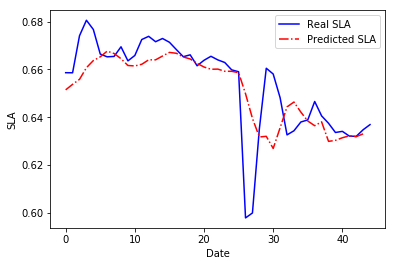

Date: 28 feb 2019 | SLA: 63.47% 

=============================== Customer Code::  215 

Training Evaluation:
• Train Score: 0.0095 RMSE
• Test Score: 0.0020 RMSE


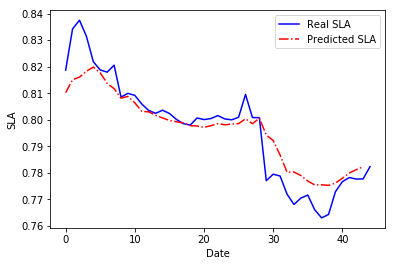

Date: 28 feb 2019 | SLA: 78.53% 

=============================== Customer Code::  2581 

Training Evaluation:
• Train Score: 0.0177 RMSE
• Test Score: 0.0059 RMSE


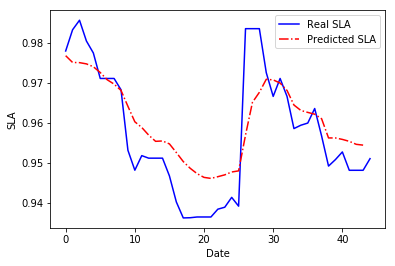

Date: 28 feb 2019 | SLA: 95.63% 

=============================== Customer Code::  3363 

Training Evaluation:
• Train Score: 0.0257 RMSE
• Test Score: 0.0090 RMSE


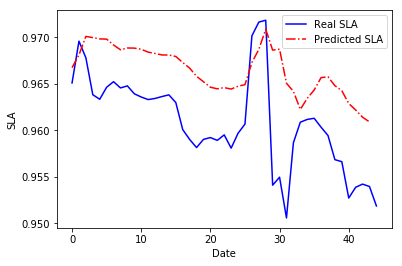

Date: 28 feb 2019 | SLA: 96.15% 

=============================== Customer Code::  8068 

Training Evaluation:
• Train Score: 0.0207 RMSE
• Test Score: 0.0117 RMSE


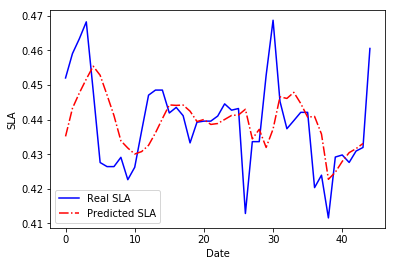

Date: 28 feb 2019 | SLA: 45.38% 

=============================== Customer Code::  87520 

Training Evaluation:
• Train Score: 0.0214 RMSE
• Test Score: 0.0165 RMSE


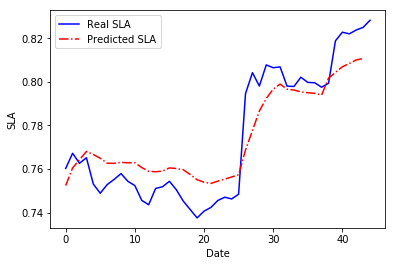

Date: 28 feb 2019 | SLA: 80.99% 

=============================== Customer Code::  900995 

Training Evaluation:
• Train Score: 0.0670 RMSE
• Test Score: 0.0160 RMSE


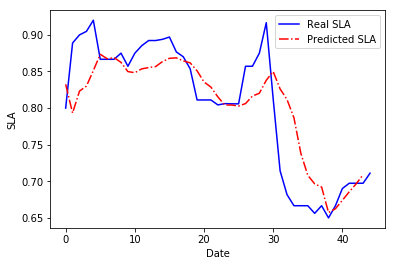

Date: 28 feb 2019 | SLA: 72.16% 

=============================== Customer Code::  39159 

Training Evaluation:
• Train Score: 0.1417 RMSE
• Test Score: 0.0407 RMSE


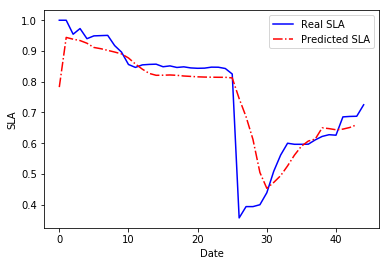

Date: 28 feb 2019 | SLA: 69.66% 

=============================== Customer Code::  797391 

Training Evaluation:
• Train Score: 0.1819 RMSE
• Test Score: 0.0239 RMSE


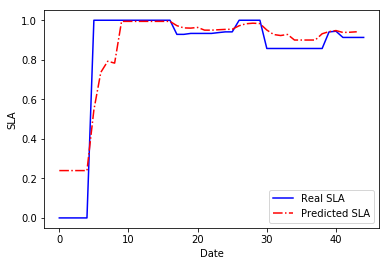

Date: 28 feb 2019 | SLA: 94.55% 



In [6]:
for c in customers:
    predict_sla_for_customer(c, df, look_back=5)

### Comparison with the last day of Jan

In [7]:
df[(df.currentDate >= '2019-01-31')  & (df.currentDate < '2019-02-01')]

,currentDate,customerCode,sla
270,2019-01-31,797391,0.941176
271,2019-01-31,39159,0.825175
272,2019-01-31,900995,0.805825
273,2019-01-31,87520,0.748452
274,2019-01-31,8068,0.443213
275,2019-01-31,2581,0.939216
276,2019-01-31,215,0.800931
277,2019-01-31,372301,0.659013
278,2019-01-31,3363,0.960671
